介绍如何在tensorflow环境下，使用FGSM算法攻击基于Inception数据集预训练的alexnet模型。

Jupyter notebook中使用Anaconda中的环境需要单独配置，默认情况下使用的是系统默认的Python环境，以使用advbox环境为例。
首先在默认系统环境下执行以下命令，安装ipykernel。

    conda install ipykernel
    conda install -n advbox ipykernel

在advbox环境下激活，这样启动后就可以在界面上看到advbox了。

    python -m ipykernel install --user --name advbox --display-name advbox 


In [1]:
import logging
logging.basicConfig(level=logging.INFO,format="%(filename)s[line:%(lineno)d] %(levelname)s %(message)s")
logger=logging.getLogger(__name__)

import numpy as np
from PIL import Image
#pip install Pillow
from advbox.adversary import Adversary
#from advbox.attacks.gradient_method import FGSM
from advbox.attacks.gradient_method import FGSMT
from advbox.models.tensorflow import TensorflowModel
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tools import show_images_diff

In [2]:
#定义被攻击的图片
imagename="tutorials/cropped_panda.jpg"
#从'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'下载并解压到当前路径
dirname="classify_image_graph_def.pb"

In [3]:
#加载解码的图像 这里是个大坑 tf提供的imagenet预训练好的模型pb文件中 包含针对图像的预处理环节 即解码jpg文件 这部分没有梯度
#需要直接处理解码后的数据
image=np.array(Image.open(imagename).convert('RGB').resize((224,224))).astype(np.float32)
#[100,100,3]->[1,100,100,3]

orig=image.copy().astype(np.uint8) 

image=np.expand_dims(image, axis=0)

  

session=tf.Session()

def create_graph(dirname):
    with tf.gfile.FastGFile(dirname, 'rb') as f:
        graph_def = session.graph_def
        graph_def.ParseFromString(f.read())

        _ = tf.import_graph_def(graph_def, name='')

create_graph(dirname)

# 初始化参数  非常重要
session.run(tf.global_variables_initializer())

tensorlist=[n.name for n in session.graph_def.node]

#输出全部tensor
#logger.info(tensorlist)


#获取logits
logits=session.graph.get_tensor_by_name('softmax/logits:0')

x = session.graph.get_tensor_by_name('ExpandDims:0')

# advbox demo
# 因为原始数据没有归一化  所以bounds=(0, 255)
m = TensorflowModel(
    session,
    x,
    None,
    logits,
    None,
    bounds=(0, 255),
    channel_axis=3,
    preprocess=None)

#实例化FGSM 进行定向攻击 
attack = FGSMT(m)
attack_config = {"epsilons": 10, "epsilons_max": 10, "epsilon_steps": 1, "steps": 100}

adversary = Adversary(image,None)
#麦克风
tlabel = 651
adversary.set_target(is_targeted_attack=True, target_label=tlabel)

# FGSM targeted attack
adversary = attack(adversary, **attack_config)

if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label) )

    #对抗样本保存在adversary.adversarial_example
    adversary_image=np.copy(adversary.adversarial_example)
    #强制类型转换 之前是float 现在要转换成int8

    adv = np.array(adversary_image).astype("uint8")[0]

 

print("fgsm attack done")

tensorflow.py[line:63] INFO self._input_shape:(Dimension(None), Dimension(None), Dimension(3))
tensorflow.py[line:65] INFO init grads[1008]...
tensorflow.py[line:72] INFO Finish TensorflowPBModel init
base.py[line:87] INFO adversary:
         original_label: 169
         target_label: 651
         is_targeted_attack: True
gradient_method.py[line:86] INFO epsilons=10,epsilons_max=10,steps=100,epsilon_steps=1
tensorflow.py[line:127] INFO Start to get _grads[651]
tensorflow.py[line:129] INFO Finish to get _grads[651]
gradient_method.py[line:133] INFO step=1, epsilon = 10.00000, pre_label = 169, adv_label=169 logits=11.2586631775
gradient_method.py[line:133] INFO step=2, epsilon = 10.00000, pre_label = 169, adv_label=169 logits=8.53412723541
gradient_method.py[line:133] INFO step=3, epsilon = 10.00000, pre_label = 169, adv_label=226 logits=5.82358455658
gradient_method.py[line:133] INFO step=4, epsilon = 10.00000, pre_label = 169, adv_label=986 logits=6.51778793335
gradient_method.py[line:

attack success, adversarial_label=651
fgsm attack done


l0=150379 l2=65875.2890999


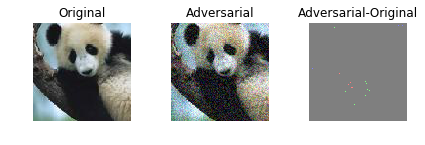

In [4]:
#显示原始图片  抵抗样本 以及两张图之间的差异  其中灰色代表没有差异的像素点
show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)
